# <span style="font-size: 1em">Art Unveiled: Enhancing Access to Arts for the Visually Impaired</span><span style="font-size: 0.8em"> Final Assignment</span>
<h3>Machine Learning and Content Analytics (M.L.C.A.) 2022-2023</h3>
<h5>M.Sc. In Business Analytics (Part Time) 2022-2024 at Athens University of Economics and Business (A.U.E.B.)</h5>

---

> **_Team Name_**: Tango<br />
> **_Students_**: Panagiotis Vaidomarkakis, Alexandros Lemonidis, Katerina Gioupai<br />
> **_Student I.D.s_**: p2822203, p282214, p282208 <br />
> **_Instructors_**: Haris Papageorgiou, George Perakis<br />
> **_Due Date_**: 17/09/2023

## Table Of Contents:
* [Importing Libraries](#q0)
* [$1^{st}$ Task : Augment from *125* images to **_1000_** with bounding boxes](#q1)
* [$2^{nd}$ Task : Tune and train the *best* **_YOLO_** model in order to predict](#q2)
* [$3^{rd}$ Task : Connect with **_Bard_ API** in order to have a description for an image](#q3)
* [$4^{th}$ Task : Transform **_text_** to **_sound_**](#q4)

## Importing Libraries <a class="anchor" id="q0"></a>
In the following lines, we will import all the nessecary libraries in order to be able to execute all the following commands. <br> First, we will run a check to see if the PC containing this Jupiter Notebook file has all the necessary libraries and if it hasn't, it will automatically download them in order to import them:

In [1]:
import importlib
import subprocess

def install_library(lib):
    try:
        importlib.import_module(lib)
        print(f'{lib} is already installed.')
    except ImportError:
        print(f'{lib} is not installed. Installing now...')
        subprocess.call(['pip', 'install', lib])

libraries = ['ultralytics','os','cv2','numpy','google.colab','albumentations','sklearn','tqdm','pandas','tabulate','bardapi','gtts']

for lib in libraries:
    install_library(lib)

ultralytics is not installed. Installing now...
os is already installed.
cv2 is already installed.
numpy is already installed.
google.colab is already installed.
albumentations is already installed.
sklearn is already installed.
tqdm is already installed.
pandas is already installed.
tabulate is already installed.
bardapi is not installed. Installing now...
gtts is not installed. Installing now...


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
import numpy as np
import json
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A
from google.colab.patches import cv2_imshow
import shutil
from ultralytics import YOLO, settings
from sklearn.model_selection import ParameterGrid
import yaml
from tqdm import tqdm
import torch
import statistics
import pandas as pd
from tabulate import tabulate
from bardapi import Bard
from gtts import gTTS
from IPython.display import Audio

Mounted at /content/drive


Before we begin, we need to specify some basic directories in order to call them through the code.

In [3]:
# Define the images and labels path
img_directory = '/content/drive/MyDrive/all_data_final/images'
txt_directory = '/content/drive/MyDrive/all_data_final/labels'
json_filename = '/content/drive/MyDrive/all_data_final/notes.json'

# Uncomment and comment the above if you need to "see" an image in training dataset
"""img_directory = '/content/drive/MyDrive/all_data_final/train/images'
txt_directory = '/content/drive/MyDrive/all_data_final/train/labels'"""

"img_directory = '/content/drive/MyDrive/all_data_final/train/images'\ntxt_directory = '/content/drive/MyDrive/all_data_final/train/labels'"

## $1^{st}$ Task : Augment from *125* images to **_1000_** with bounding boxes<a class="anchor" id="q1"></a>
Our dataset has **125** custom images.<br>
First of all, we need to rename all our images in the form of **00001.jpg, 00002.jpg, 00003.jpg** etc. in order to be easier for us to split train/test/val datasets.<br>Below is the code for renaming.<br>

In [ ]:
# Ensure the target folders exist
os.makedirs(img_directory, exist_ok=True)
os.makedirs(txt_directory, exist_ok=True)

# List the files in the source folders
image_files = sorted([f for f in os.listdir(img_directory) if f.endswith('.jpg')])
label_files = sorted([f for f in os.listdir(txt_directory) if f.endswith('.txt')])

# Rename image files
for i, image_file in enumerate(image_files, start=1):
    src_image_path = os.path.join(img_directory, image_file)
    dest_image_path = os.path.join(txt_directory, f"{i:05d}.jpg")
    os.rename(src_image_path, dest_image_path)

# Rename label files
for i, label_file in enumerate(label_files, start=1):
    src_label_path = os.path.join(img_directory, label_file)
    dest_label_path = os.path.join(txt_directory, f"{i:05d}.txt")
    os.rename(src_label_path, dest_label_path)

print("Files renamed successfully.")

Files renamed successfully.


Now, it is the time for augmentation. We will use our **_125_** images in order to have in the end **_1000_** images with the corresponding labels.

In [ ]:
# Define your custom_augmentation function here
def custom_augmentation(p):
    return A.Compose([
        A.RandomSizedBBoxSafeCrop(width=189, height=266, p=p),
        A.RandomScale(p=1-p),
        A.Rotate(p=p),
        A.RandomBrightnessContrast(p=p),
        A.RandomRain(brightness_coefficient=0.7, drop_width=1, blur_value=5, p=1-p),
        A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=p)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

# Function to parse the .txt file
def parse_txt_file(file_path):
    category_ids = []
    bboxes = []

    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 5:
                category_ids.append(int(parts[0]))
                bbox = [float(x) for x in parts[1:]]
                # Ensure bounding box coordinates are within [0.0, 1.0] range
                bbox = [max(min(x, 1.0), 0.0) for x in bbox]
                bboxes.append(bbox)

    return category_ids, bboxes

# Function to filter categories by IDs
def filter_categories_by_ids(json_file_path, category_ids):
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)

    categories = data.get("categories", [])

    category_id_to_name = {category["id"]: category["name"] for category in categories if category.get("id") in category_ids}

    return category_id_to_name

# Get a list of all .txt files in the directory
txt_files = [os.path.splitext(f)[0] for f in os.listdir(txt_directory) if f.endswith('.txt')]

# Set the seed range based on the number of images you want (1000 in our case)
seed_range = range(1, 1001)

# Iterate through each .txt file and process it with different seeds
for i, txt_file in enumerate(txt_files):
    # Calculate the current seed based on the index of the txt_file
    seed = seed_range[i % len(seed_range)]

    txt_file_path = os.path.join(txt_directory, f"{txt_file}.txt")
    img_file_path = os.path.join(img_directory, f"{txt_file}.jpg")
    category_ids, bboxes = parse_txt_file(txt_file_path)
    image = cv2.imread(img_file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category_id_to_name = filter_categories_by_ids('/content/drive/MyDrive/all_data_final/notes.json', category_ids)

    print(f"Processing {txt_file} image...")
    random.seed(seed)  # Set the seed for this iteration

    # Sample and apply random probabilities in a loop
    for i in range(1, 8):
        # Generate random probability between 0.01 and 1.0
        random_prob = random.uniform(0.01, 1.0)

        # Apply the transformation with the random probability
        transform = custom_augmentation(random_prob)
        transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)

        # Ensure bounding box coordinates are within [0.0, 1.0] range
        for j in range(len(transformed['bboxes'])):
            transformed['bboxes'][j] = [max(min(x, 1.0), 0.0) for x in transformed['bboxes'][j]]

        # Generate the new image name using mathematical operations
        new_image_name = f"{int(txt_file) + (i * len(txt_files)):05d}"
        print(f"Processing {new_image_name} image...")
        # Save the transformed image with the new name
        output_path = os.path.join(img_directory, f"{new_image_name}.jpg")
        cv2.imwrite(output_path, transformed['image'])

        # Create a list of strings with the desired format for the annotation
        annotation_data = []
        for category_id, bbox in zip(transformed['category_ids'], transformed['bboxes']):
            bbox_str = ' '.join(map(str, bbox))
            annotation_str = f"{category_id} {bbox_str}"
            annotation_data.append(annotation_str)

        # Save the annotation data as a text file
        output_annotation_path = os.path.join(txt_directory, f"{new_image_name}.txt")
        with open(output_annotation_path, 'w') as annotation_file:
            annotation_file.write('\n'.join(annotation_data))
print('Augmentation of 1000 completed!')

Processing 00001 image...
Processing 00126 image...
Processing 00251 image...
Processing 00376 image...
Processing 00501 image...
Processing 00626 image...
Processing 00751 image...
Processing 00876 image...
Processing 00002 image...
Processing 00127 image...
Processing 00252 image...
Processing 00377 image...
Processing 00502 image...
Processing 00627 image...
Processing 00752 image...
Processing 00877 image...
Processing 00003 image...
Processing 00128 image...
Processing 00253 image...
Processing 00378 image...
Processing 00503 image...
Processing 00628 image...
Processing 00753 image...
Processing 00878 image...
Processing 00004 image...
Processing 00129 image...
Processing 00254 image...
Processing 00379 image...
Processing 00504 image...
Processing 00629 image...
Processing 00754 image...
Processing 00879 image...
Processing 00005 image...
Processing 00130 image...
Processing 00255 image...
Processing 00380 image...
Processing 00505 image...
Processing 00630 image...
Processing 0

Below, we can see some of them in order to evaluate that the both *images* and *bounding boxes* ended up right.

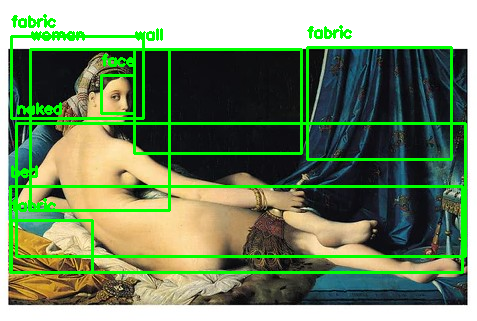

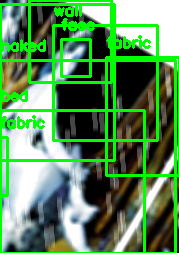

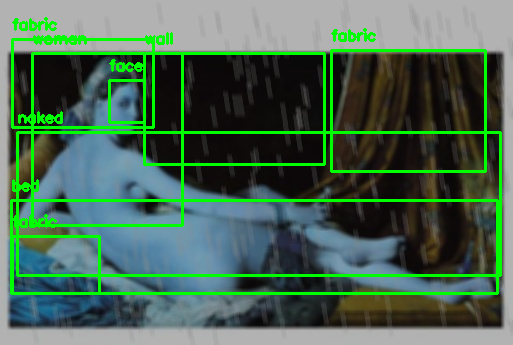

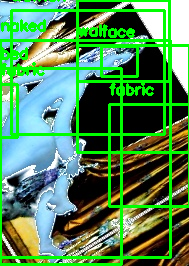

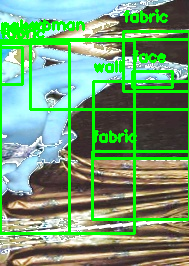

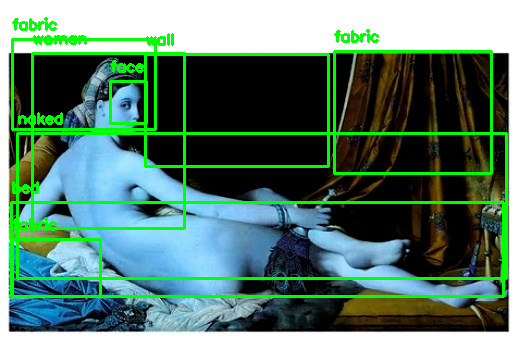

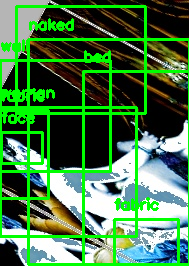

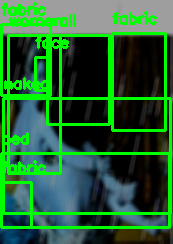

In [63]:
# Define a function to load class names from a JSON file
def load_class_names(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
        class_names = {str(category["id"]): category["name"] for category in data["categories"]}
    return class_names

# Load the class names from your JSON file
class_names = load_class_names(json_filename)

def process_image_with_labels(image_filename):
    # Construct the full image path
    image_path = os.path.join(img_directory, f'{image_filename}.jpg')
    # Load the image
    image = cv2.imread(image_path)

    # Construct the full label file path
    label_path = os.path.join(txt_directory, f'{image_filename}.txt')

    # Read the label file and parse bounding box coordinates
    with open(label_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        data = line.strip().split()
        class_id = int(data[0])
        class_name = data[0]
        x_center, y_center, width, height = map(float, data[1:])

        # Convert YOLO format coordinates to image coordinates
        image_h, image_w, _ = image.shape
        x_center *= image_w
        y_center *= image_h
        width *= image_w
        height *= image_h

        # Calculate bounding box coordinates
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        # Get the class name based on class_id
        class_name = class_names.get(str(class_id), 'Unknown')

        # Define colors for bounding boxes (you can customize these)
        color = (0, 255, 0)  # Green
        label = f'{class_name}'  # Display class name instead of class_id

        # Draw bounding boxes and labels on the image
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image with bounding boxes and labels
    cv2_imshow(image)

# Call the function 8 times with incrementing image filenames
start_filename = 19
# Comment the below for loop if you want to predict
for i in range(8):
    process_image_with_labels(f'{start_filename + i * 125:05d}')

Below is a debugging code because some images had weird bounding boxes which exceeded the image size so whenever the above process stopped, we executed the below code to find the wrong coordinate. After the fix, we deleted all the new images and start the process again.

In [ ]:
"""
def yolobbox2bbox(x,y,w,h):
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    return x1, y1, x2, y2

yolobbox2bbox(0.8902968573045098, 0.6646292215882593, 0.2285750875662071, 0.1271188447759193)
"""

(0.7760093135214062, 0.6010697992002997, 1.0045844010876133, 0.728188643976219)

Below is the code which delete both images and texts from 00126 and beyond.

In [ ]:
"""
labels_directory = '/content/drive/MyDrive/all_data_final/labels'
images_directory = '/content/drive/MyDrive/all_data_final/images'
prefix_to_keep = '00126'

# List all files in the labels directory
labels_files = os.listdir(labels_directory)

# Iterate through the files and delete files with a greater or equal filename
for label_file in labels_files:
    if label_file >= f'{prefix_to_keep}.txt':
        # Construct the full label file path
        label_file_path = os.path.join(labels_directory, label_file)

        # Check if the file is a .txt file and delete it
        if label_file.endswith('.txt') and os.path.isfile(label_file_path):
            os.remove(label_file_path)
            print(f"Deleted: {label_file}")

            # Construct the corresponding image file path
            image_file = label_file.replace('.txt', '.jpg')
            image_file_path = os.path.join(images_directory, image_file)

            # Check if the corresponding image file exists and delete it
            if os.path.isfile(image_file_path):
                os.remove(image_file_path)
                print(f"Deleted: {image_file}")
"""

Deleted: 00126.txt
Deleted: 00126.jpg
Deleted: 00251.txt
Deleted: 00251.jpg
Deleted: 00376.txt
Deleted: 00376.jpg
Deleted: 00501.txt
Deleted: 00501.jpg
Deleted: 00626.txt
Deleted: 00626.jpg
Deleted: 00751.txt
Deleted: 00751.jpg
Deleted: 00876.txt
Deleted: 00876.jpg
Deleted: 00127.txt
Deleted: 00127.jpg
Deleted: 00252.txt
Deleted: 00252.jpg
Deleted: 00377.txt
Deleted: 00377.jpg
Deleted: 00502.txt
Deleted: 00502.jpg
Deleted: 00627.txt
Deleted: 00627.jpg
Deleted: 00752.txt
Deleted: 00752.jpg
Deleted: 00877.txt
Deleted: 00877.jpg
Deleted: 00128.txt
Deleted: 00128.jpg
Deleted: 00253.txt
Deleted: 00253.jpg
Deleted: 00378.txt
Deleted: 00378.jpg
Deleted: 00503.txt
Deleted: 00503.jpg
Deleted: 00628.txt
Deleted: 00628.jpg
Deleted: 00753.txt
Deleted: 00753.jpg
Deleted: 00878.txt
Deleted: 00878.jpg
Deleted: 00129.txt
Deleted: 00129.jpg
Deleted: 00254.txt
Deleted: 00254.jpg
Deleted: 00379.txt
Deleted: 00379.jpg
Deleted: 00504.txt
Deleted: 00504.jpg
Deleted: 00629.txt
Deleted: 00629.jpg
Deleted: 007

Before we move on, we need to split our dataset to train dataset and validation dataset.<br>
We kept **_3_** images on purpose in order to predict them and we wanted to put on train dataset all of the remaining **_122_** original images plus the majority of the augmented images.<br>
We left only augmented images to the validation dataset.

In [ ]:
# Set the paths for destination train, validation and predict directories
train_images_dest_dir = '/content/drive/MyDrive/all_data_final/train/images'
train_labels_dest_dir = '/content/drive/MyDrive/all_data_final/train/labels'
val_images_dest_dir = '/content/drive/MyDrive/all_data_final/val/images'
val_labels_dest_dir = '/content/drive/MyDrive/all_data_final/val/labels'
pred_images_dest_dir = '/content/drive/MyDrive/all_data_final/predict'

# Create destination directories if they don't exist
os.makedirs(train_images_dest_dir, exist_ok=True)
os.makedirs(train_labels_dest_dir, exist_ok=True)
os.makedirs(val_images_dest_dir, exist_ok=True)
os.makedirs(val_labels_dest_dir, exist_ok=True)
os.makedirs(pred_images_dest_dir, exist_ok=True)

# List all the image files in the source directory
image_files = sorted([f for f in os.listdir(img_directory) if f.endswith('.jpg')])

# Set the random seed for reproducibility
random.seed(42)

# Iterate through each image and label, moving them to the appropriate destination
for i, image_file in enumerate(image_files):
    label_file = image_file.replace('.jpg', '.txt')

    if i in [10,14,68]:
        # Move to predict
        shutil.move(os.path.join(img_directory, image_file), os.path.join(pred_images_dest_dir, image_file))
        shutil.move(os.path.join(txt_directory, label_file), os.path.join(pred_images_dest_dir, label_file))
    elif i < 122 or random.random() <= 900 / 997:
      # Move to train
        shutil.move(os.path.join(img_directory, image_file), os.path.join(train_images_dest_dir, image_file))
        shutil.move(os.path.join(txt_directory, label_file), os.path.join(train_labels_dest_dir, label_file))
    else:
        # Move to val
        shutil.move(os.path.join(img_directory, image_file), os.path.join(val_images_dest_dir, image_file))
        shutil.move(os.path.join(txt_directory, label_file), os.path.join(val_labels_dest_dir, label_file))

print("Images and labels moved at random at train and val directories accordingly.")

Images and labels moved at random at train and val directories accordingly.


Below is the code that brings the file back to the source in case we want to change train and validation datasets.

In [ ]:
"""
# Move images and labels from train directory back to source
train_image_files = os.listdir(train_images_dest_dir)
for image_file in train_image_files:
    label_file = image_file.replace('.jpg', '.txt')

    shutil.move(os.path.join(train_images_dest_dir, image_file), os.path.join(img_directory, image_file))
    shutil.move(os.path.join(train_labels_dest_dir, label_file), os.path.join(txt_directory, label_file))

# Move images and labels from validation directory back to source
val_image_files = os.listdir(val_images_dest_dir)
for image_file in val_image_files:
    label_file = image_file.replace('.jpg', '.txt')

    shutil.move(os.path.join(val_images_dest_dir, image_file), os.path.join(img_directory, image_file))
    shutil.move(os.path.join(val_labels_dest_dir, label_file), os.path.join(txt_directory, label_file))

print("Images and labels moved back to the original source directories.")
"""

Images and labels moved back to the original source directories.


## $2^{nd}$ Task : Tune and train the *best* **_YOLO_** model in order to predict<a class="anchor" id="q2"></a>
Below is the code for tuning the YOLO model as far as we can go in order to keep the **best** model for our need.<br>
After that, we save in a **.pt** format that model to keep going for predictions.<br>
Below, we are setting all the parameters that we want in order to be able to train **_36_** different models.<br>
We could have tried for more but we didn't have unlimited resources to do that.

In [ ]:
settings.update({'runs_dir': '/content/drive/MyDrive/all_data_final'})
# Define hyperparameters to tune
#learning_rates = [0.0001, 0.001, 0.01]
#batch_sizes = [32, 64, 96]
network_architectures = ['yolov8n', 'yolov8m']
activation_functions = ['LeakyReLU', 'SiLU', 'Swish']
optimizers = ['SGD', 'AdamW', 'RMSProp']#, 'Adam', 'Adamax', 'NAdam', 'RAdam']
epochs = [30, 50]

# Set up the search space
search_space = {
                'optimizer': optimizers,
                'epochs': epochs,
                'network_architecture': network_architectures,
                'activation_function': activation_functions,
                }

# Create parameter grid
parameter_grid = ParameterGrid(search_space)

# Create a directory to save models
output_dir = '/content/drive/MyDrive/all_data_final/trained_models'
os.makedirs(output_dir, exist_ok=True)

Below is the code for training each of the 36 models with the same training dataset.

In [ ]:
# Train the model for each combination of hyperparameters
for parameters in tqdm(parameter_grid):
    optimizer = parameters['optimizer']
    num_epochs = parameters['epochs']
    architecture = parameters['network_architecture']
    activation = parameters['activation_function']

    # Define a unique model name based on hyperparameters
    model_name = f"mod_{architecture}_af{activation}_opt{optimizer}_epochs{num_epochs}"#_pat{patience}"

    # Define the path to your data_custom.yaml file
    data_custom_path = '/content/drive/MyDrive/all_data_final/data_custom.yaml'

    # Read the content of the data_custom.yaml file
    with open(data_custom_path, 'r') as yaml_file:
        yaml_data = yaml.load(yaml_file, Loader=yaml.FullLoader)

    # Modify the 'activation' line with the current 'activation_function'
    yaml_data['activation'] = f'nn.{activation}()'

    # Save the modified content back to the data_custom.yaml file without quotes
    with open(data_custom_path, 'w') as yaml_file:
        yaml.dump(yaml_data, yaml_file, default_flow_style=False)

    # Load a YOLOv8n model
    model = YOLO(architecture + '.pt')

    # Train the YOLOv8 model using Ultralytics
    model.train(
        data=data_custom_path,
        imgsz=640,   # Set your image size
        optimizer=optimizer,   # Set optimizer
        cache = True,   # Load images on RAM to rest GPU for calculations
        batch=75,
        epochs=num_epochs,
        seed=42,   # In order to have reproducible results
        project=output_dir,
        name=model_name,
        exist_ok=True,   # Rewrite if exists
        plots=False,
        mode='train',
        task='detect',
        val=False
    )

  0%|          | 0/1 [00:00<?, ?it/s]Ultralytics YOLOv8.0.178 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/all_data_final/data_custom.yaml, epochs=50, patience=50, batch=75, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/all_data_final/trained_models, name=mod_yolov8m_afSwish_optAdamW_epochs50, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer

We need to evaluate our models based on some metrics.<br>
So, below we start to evaluate the models using varius metrics such as **_mean precision_**, **_mean recall_**, **_mean Average Precision (mAP)_** at an IoU threshold of 0.5 and **_mean Average Precision (mAP)_** over IoU thresholds of 0.5 - 0.95 in steps of 0.05.<br>
We will compare each model based on the mean of these **_4_** metrics in order to keep the best one for tuning it.

In [ ]:
# Initialize variables to track the best model and its performance
best_model_final = None
best_mAR = -1  # Initialize with a very low value
model_name_final = None
model_info_list = [] # Initialize an empty list to store the model information

# Evaluate the model for each combination of hyperparameters
for parameters in tqdm(parameter_grid):
    optimizer = parameters['optimizer']
    num_epochs = parameters['epochs']
    architecture = parameters['network_architecture']
    activation = parameters['activation_function']

    # Define a unique model name based on hyperparameters
    model_name = f"mod_{architecture}_af{activation}_opt{optimizer}_epochs{num_epochs}"

    # Evaluate the trained model and get mAR (mean Average Results)
    with torch.no_grad():
        # Load the trained model
        print(model_name)
        val_model = YOLO(output_dir + '/' + model_name + '/weights/best.pt')

        results = val_model.val(plots=True)
        print(results.mean_results())  # Return mean precision, mean recall, mean Average Precision (mAP) at an IoU threshold of 0.5, mean Average Precision (mAP) over IoU thresholds of 0.5 - 0.95 in steps of 0.05
        mean_mAR = statistics.mean(results.mean_results())

        model_info = {
            'Model Name': model_name,
            'Mean Precision': results.mean_results()[0],  # Mean precision
            'Mean Recall': results.mean_results()[1],     # Mean recall
            'mAP@0.5': results.mean_results()[2],         # mAP at IoU=0.5
            'mAP@0.5-0.95': results.mean_results()[3],    # mAP over IoU thresholds from 0.5 to 0.95 with 0.05 step
            'Mean mAR': mean_mAR  # Mean mAR
        }
        model_info_list.append(model_info)

        # Check if this model has the best score so far
        if mean_mAR > best_mAR:
            best_mAR = mean_mAR
            best_model_final = results  # Update the best model
            model_name_final = model_name

            # Save the results
            result = {
                'network_architecture': architecture,
                'optimizer': optimizer,
                'num_epochs': num_epochs,
                'activation_function': activation,
                'mAR': best_mAR
            }

model_info_df = pd.DataFrame(model_info_list).sort_values(by='Mean mAR', ascending=False)
model_info_df.to_csv('/content/drive/MyDrive/all_data_final/model_info.csv', index=False)
print(model_info_df)

print("Best Model:")
print(model_name_final)
print("Best Parameters:")
print(result)

Below is a summarized table with **_all_** the different models that we tested, including **_Mean Precision_**, **_Mean Recall_**, **_mAP\@0.5_** (Mean Average Precision with Intersection over Union 50%), **_mAP\@0.5-0.95_** (Mean Average Precision with Intersection over Union from 50% to 95% with 5% step) and **_Mean mAR_** (The mean of all the previous result scores).

In [ ]:
model_info_df = pd.read_csv('/content/drive/MyDrive/all_data_final/model_info.csv').sort_values(by='Mean mAR', ascending=False)
print(tabulate(model_info_df, headers='keys', tablefmt='fancy_grid'))

╒════╤═════════════════════════════════════════════╤══════════════════╤═══════════════╤════════════╤════════════════╤════════════╕
│    │ Model Name                                  │   Mean Precision │   Mean Recall │    mAP@0.5 │   mAP@0.5-0.95 │   Mean mAR │
╞════╪═════════════════════════════════════════════╪══════════════════╪═══════════════╪════════════╪════════════════╪════════════╡
│ 21 │ mod_yolov8m_afSiLU_optSGD_epochs50          │       0.885758   │      0.751786 │ 0.848951   │     0.64841    │  0.783726  │
├────┼─────────────────────────────────────────────┼──────────────────┼───────────────┼────────────┼────────────────┼────────────┤
│  9 │ mod_yolov8m_afLeakyReLU_optSGD_epochs50     │       0.885758   │      0.751786 │ 0.848951   │     0.64841    │  0.783726  │
├────┼─────────────────────────────────────────────┼──────────────────┼───────────────┼────────────┼────────────────┼────────────┤
│ 33 │ mod_yolov8m_afSwish_optSGD_epochs50         │       0.885758   │      0.7517

From the above table, we can see that **_50_** epochs and **_SGD_** optimizer are some parameters that gives us the best results. So, we will keep them and we will tune all the other **_hyperparameters_**. We need many steps to do a proper tuning (above **_300_**) but we don't have unlimited resources so we do only **_25_**.

In [ ]:
# Read the content of the data_custom.yaml file
with open(data_custom_path, 'r') as yaml_file:
    yaml_data = yaml.load(yaml_file, Loader=yaml.FullLoader)

# Modify the 'activation' line with the current 'activation_function'
yaml_data['activation'] = f'nn.{result['network_architecture']}()'

# Save the modified content back to the data_custom.yaml file without quotes
with open(data_custom_path, 'w') as yaml_file:
    yaml.dump(yaml_data, yaml_file, default_flow_style=False)

# Tune hyperparameters on COCO8 for 30 epochs
best_model_final.tune(data=data_custom_path, epochs=result['num_epochs'], iterations=25, optimizer=result['optimizer'], plots=False, save=False, val=False)

Now, it is time to write a new **_yaml_** file, containing both the location of train and validation datasets, number of classes and the classes as far as the tuned hyperparameters.

In [ ]:
# Define the paths to the input YAML files
yaml_old = "/content/drive/MyDrive/all_data_final/data_custom.yaml"
yaml_best = "/content/drive/MyDrive/all_data_final/detect/tune/best_hyperparameters.yaml"

# Define the path to the output YAML file
output_file = "/content/drive/MyDrive/all_data_final/data_custom_final.yaml"

# Read the content of the first YAML file
with open(yaml_old, 'r') as file1:
    data1 = yaml.safe_load(file1)

# Read the content of the second YAML file
with open(yaml_best, 'r') as file2:
    data2 = yaml.safe_load(file2)

# Merge the data from both files
merged_data = {**data1, **data2}

# Save the modified content back to the data_custom.yaml file without quotes
with open(output_file, 'w') as yaml_file:
    yaml.dump(merged_data, yaml_file, default_flow_style=False)

print(f"Concatenated data has been saved to {output_file}")

Concatenated data has been saved to /content/drive/MyDrive/all_data_final/data_custom_final.yaml


Because the first **_3_** models had the same scores, we will re-train only these models and validate them to get the best model for our data.

In [ ]:
network_architectures = ['yolov8m']
activation_functions = ['LeakyReLU', 'SiLU', 'Swish']
optimizers = ['SGD']
epochs = [50]

# Set up the search space
search_space = {'optimizer': optimizers,
                'epochs': epochs,
                'network_architecture': network_architectures,
                'activation_function': activation_functions,
                }

# Create parameter grid
parameter_grid = ParameterGrid(search_space)

# Create a directory to save models
output_dir = '/content/drive/MyDrive/all_data_final/final_models'
os.makedirs(output_dir, exist_ok=True)

# Initialize variables to track the best model and its performance
best_model_final = None
best_mAR = -1  # Initialize with a very low value
model_name_final = None
model_info_list = []

# Train the model for each combination of hyperparameters
for parameters in tqdm(parameter_grid):
    # Set hyperparameters for the model
    optimizer = parameters['optimizer']
    num_epochs = parameters['epochs']
    architecture = parameters['network_architecture']
    activation = parameters['activation_function']

    # Define a unique model name based on hyperparameters
    model_name = f"final_mod_{architecture}_af{activation}_opt{optimizer}_epochs{num_epochs}"

    with open(output_file, 'r') as yaml_file:
      yaml_data = yaml.safe_load(yaml_file)

    # Modify the 'activation' line with the current 'activation_function'
    yaml_data['activation'] = f'nn.{activation}()'

    # Save the modified content back to the data_custom.yaml file without quotes
    with open(output_file, 'w') as yaml_file:
        yaml.dump(yaml_data, yaml_file, default_flow_style=False)

    # Load a YOLOv8n model
    model = YOLO(architecture + '.pt')

    # Train the YOLOv8 model using Ultralytics
    model.train(
        data=output_file,
        imgsz=640,
        optimizer=optimizer,
        cache = True,
        batch=90,
        epochs=num_epochs,
        seed=42,
        project=output_dir,
        name=model_name,
        exist_ok=True,
        plots=True,
        mode='train',
        task='detect',
        val=False,
        lr0=0.01915,
        lrf=0.01034,
        momentum=0.94117,
        weight_decay=0.00032,
        warmup_epochs=2.3912,
        warmup_momentum=0.55326,
        box=7.95282,
        cls=0.58789,
        dfl=0.96978
    )

    # Evaluate the trained model and get mAR (mean Average Results)
    with torch.no_grad():
        # Load the trained model
        print(model_name)
        val_model = YOLO(output_dir + '/' + model_name + '/weights/best.pt')

        results = val_model.val(plots=True)
        print(results.mean_results())  # Return mean precision, mean recall, mean Average Precision (mAP) at an IoU threshold of 0.5, mean Average Precision (mAP) over IoU thresholds of 0.5 - 0.95 in steps of 0.05
        mean_mAR = statistics.mean(results.mean_results())

        model_info = {
            'Model Name': model_name,
            'Mean Precision': results.mean_results()[0],  # Mean precision
            'Mean Recall': results.mean_results()[1],     # Mean recall
            'mAP@0.5': results.mean_results()[2],         # mAP at IoU=0.5
            'mAP@0.5-0.95': results.mean_results()[3],    # mAP over IoU thresholds from 0.5 to 0.95
            'Mean mAR': mean_mAR  # Mean mAR
        }
        model_info_list.append(model_info)

        # Check if this model has the best score so far
        if mean_mAR > best_mAR:
            best_mAR = mean_mAR
            best_model_final = results  # Update the best model
            model_name_final = model_name

            # Save the results
            result = {
                'network_architecture': architecture,
                'optimizer': optimizer,
                'num_epochs': num_epochs,
                'activation_function': activation,
                'mAR': best_mAR
            }

best_model_info_df = pd.DataFrame(model_info_list).sort_values(by='Mean mAR', ascending=False)
best_model_info_df.to_csv('/content/drive/MyDrive/all_data_final/best_model_info.csv', index=False)
print(best_model_info_df)

best_model_final = YOLO(output_dir + '/' + model_name_final + '/weights/best.pt')
print("Best Model:")
print(model_name_final)
torch.save(best_model_final, '/content/drive/MyDrive/all_data_final/best_model_final.pt')
print("Best Parameters:")
print(result)

  0%|          | 0/3 [00:00<?, ?it/s]Downloading https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m.pt to 'yolov8m.pt'...

  0%|          | 0.00/49.7M [00:00<?, ?B/s]
100%|██████████| 49.7M/49.7M [00:00<00:00, 403MB/s]
Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/all_data_final/data_custom_final.yaml, epochs=50, patience=50, batch=90, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/all_data_final/final_models, name=final_mod_yolov8m_afLeakyReLU_optSGD_epochs50, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=

final_mod_yolov8m_afLeakyReLU_optSGD_epochs50


Model summary (fused): 218 layers, 25890133 parameters, 0 gradients

val: Scanning /content/drive/MyDrive/all_data_final/val/labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00222.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00472.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00667.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00725.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00847.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00850.jpg: 1 duplicate labels removed

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/6 [00:00<?, ?it/s]
                 Class     Images  

[0.9060683938899707, 0.7104039034806175, 0.8148149676354122, 0.5967351606088528]


Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/all_data_final/data_custom_final.yaml, epochs=50, patience=50, batch=90, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/all_data_final/final_models, name=final_mod_yolov8m_afSiLU_optSGD_epochs50, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualiz

final_mod_yolov8m_afSiLU_optSGD_epochs50


Model summary (fused): 218 layers, 25890133 parameters, 0 gradients

val: Scanning /content/drive/MyDrive/all_data_final/val/labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00222.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00472.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00667.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00725.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00847.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00850.jpg: 1 duplicate labels removed

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/6 [00:00<?, ?it/s]
                 Class     Images  

[0.886240302471195, 0.7707290134425845, 0.8727777450678028, 0.6478654375966685]


Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/all_data_final/data_custom_final.yaml, epochs=50, patience=50, batch=90, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/all_data_final/final_models, name=final_mod_yolov8m_afSwish_optSGD_epochs50, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visuali

final_mod_yolov8m_afSwish_optSGD_epochs50


Model summary (fused): 218 layers, 25890133 parameters, 0 gradients

val: Scanning /content/drive/MyDrive/all_data_final/val/labels.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00222.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00472.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00667.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00725.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00847.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/all_data_final/val/images/00850.jpg: 1 duplicate labels removed

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/6 [00:00<?, ?it/s]
                 Class     Images  

[0.8746725831229671, 0.7370062829327018, 0.8425486640279926, 0.6438173562922063]
                                      Model Name  Mean Precision  Mean Recall  \
1       final_mod_yolov8m_afSiLU_optSGD_epochs50        0.886240     0.770729   
2      final_mod_yolov8m_afSwish_optSGD_epochs50        0.874673     0.737006   
0  final_mod_yolov8m_afLeakyReLU_optSGD_epochs50        0.906068     0.710404   

    mAP@0.5  mAP@0.5-0.95  Mean mAR  
1  0.872778      0.647865  0.794403  
2  0.842549      0.643817  0.774511  
0  0.814815      0.596735  0.757006  
Best Model:
final_mod_yolov8m_afSiLU_optSGD_epochs50
Best Parameters:
{'network_architecture': 'yolov8m', 'optimizer': 'SGD', 'num_epochs': 50, 'activation_function': 'SiLU', 'mAR': 0.7944031246445626}


Our best model for us is a **_YOLO v8m_** model, with **_SiLU_** activation function, **_SGD_** optimizer and **_50_** epochs to run.<br>We will now continue with some *predictions* in order to **_evaluate_** and move on to the rest steps.

In [4]:
best_model_final = YOLO('/content/drive/MyDrive/all_data_final/final_models/final_mod_yolov8m_afSiLU_optSGD_epochs50/weights/best.pt')
# Define the directory containing the images and the path for the output directory where predicted results will be saved
pred_directory = '/content/drive/MyDrive/all_data_final/predict'

# Create the output directory if it doesn't exist
if not os.path.exists(pred_directory):
    os.makedirs(pred_directory)

# List all the image files in the input directory
image_files = [f for f in os.listdir(pred_directory) if f.endswith('.jpg')]

# Loop through each image file and perform predictions
for image_file in image_files:
    image_path = os.path.join(pred_directory, image_file)

    # Make predictions on the current image
    results = best_model_final.predict(source=image_path, conf=0.5)

    # Specify the path for the output text file
    output_file_path = os.path.join(pred_directory, f'{os.path.splitext(image_file)[0]}_predicted_results.txt')

    # Open the text file for writing
    with open(output_file_path, 'w') as output_file:
        for r in results:
            class_names_dict = r.names
            # Get class labels
            class_labels = r.boxes.cls.tolist()

            # Get coordinates (x, y, width, height) in xywh format
            coordinates_xywh = r.boxes.xywh.tolist()

            # Map class labels to class names
            class_names = [class_names_dict[int(class_label)] for class_label in class_labels]

            # Write class names and coordinates to the text file
            for class_name, coord in zip(class_names, coordinates_xywh):
                output_file.write(f"{class_name} {coord}\n")

    # Close the text file
    output_file.close()

    # Print a message to confirm that the data has been saved
    print(f"Results saved to {output_file_path}")


image 1/1 /content/drive/MyDrive/all_data_final/predict/00014.jpg: 640x608 1 beard, 1 bow, 1 cigarette, 1 collar, 1 hand, 1 jacket, 1 man, 1 moustache, 1 suit, 2 walls, 1584.9ms
Speed: 17.9ms preprocess, 1584.9ms inference, 29.6ms postprocess per image at shape (1, 3, 640, 608)



Results saved to /content/drive/MyDrive/all_data_final/predict/00014_predicted_results.txt


image 1/1 /content/drive/MyDrive/all_data_final/predict/00010.jpg: 416x640 1 beach, 1 fabric, 1 hand, 1 instrument, 1 lion, 1 moon, 2 mountains, 1 sea, 1 sky, 1 stick, 1 woman, 996.7ms
Speed: 2.3ms preprocess, 996.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Results saved to /content/drive/MyDrive/all_data_final/predict/00010_predicted_results.txt


image 1/1 /content/drive/MyDrive/all_data_final/predict/00068.jpg: 640x544 1 dress, 1 floor, 1 hat, 1 man, 2 overcoats, 1 stairs, 3 walls, 1 woman, 1280.3ms
Speed: 2.9ms preprocess, 1280.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Results saved to /content/drive/MyDrive/all_data_final/predict/00068_predicted_results.txt


Below are all **_3_** images we wanted to predict, along with the predicted bounding boxes.

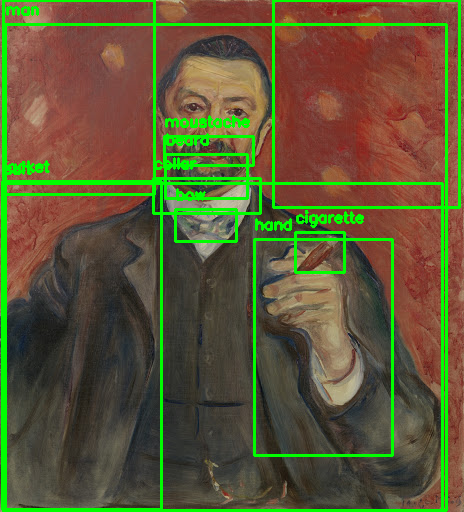

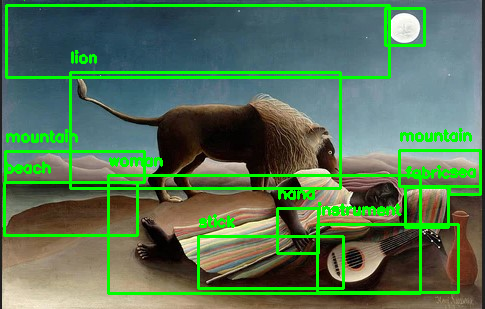

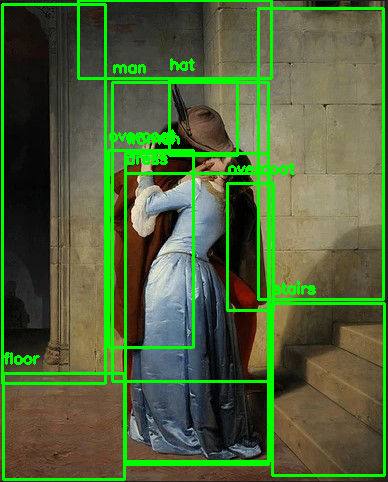

In [64]:
def display_image_with_labels(image_path, label_file_path):
    # Load the image
    image = cv2.imread(image_path)

    # Read the label file and parse bounding box coordinates and class names
    with open(label_file_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        data = line.strip().split()
        class_name = data[0]

        # Extract absolute pixel coordinates from the formatted strings
        x = float(data[1].strip('[],'))
        y = float(data[2].strip(','))
        width = float(data[3].strip(','))
        height = float(data[4].strip(']'))

        # Convert to integers based on image dimensions
        image_h, image_w, _ = image.shape
        x_min = int(x - width / 2)
        y_min = int(y - height / 2)
        x_max = int(x + width / 2)
        y_max = int(y + height / 2)

        # Define colors for bounding boxes (you can customize these)
        color = (0, 255, 0)  # Green

        # Draw bounding boxes and labels on the image
        label = class_name
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image with bounding boxes and labels
    cv2_imshow(image)

# Define the directory containing the images and the path for the label directory
image_directory = '/content/drive/MyDrive/all_data_final/predict'

# List all the image files in the input directory
image_files = [f for f in os.listdir(image_directory) if f.endswith('.jpg')]

for image_file in image_files:
    # Construct the full image and label file paths
    image_path = os.path.join(image_directory, image_file)
    label_file = os.path.splitext(image_file)[0] + '_predicted_results.txt'
    label_file_path = os.path.join(image_directory, label_file)

    # Display the image with labels
    display_image_with_labels(image_path, label_file_path)

Below we can have a comparison between **_true_** bounding boxes and **_predicted_** bounding boxes.<br>
With **_red_** bounding boxes, we can see the actual bounding boxes that we wanted to predict and with **_green_** bounding boxes, we have the predictions.

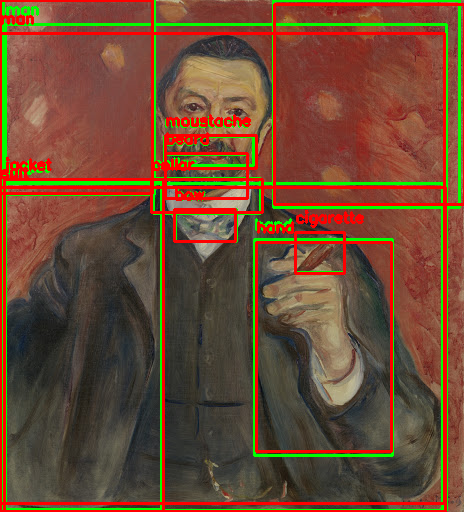

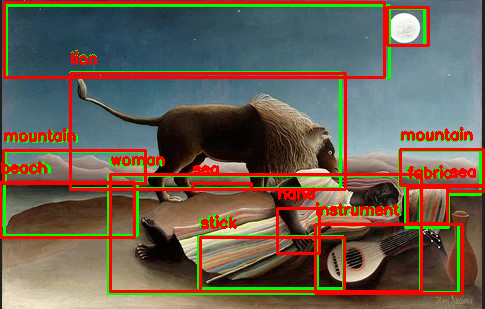

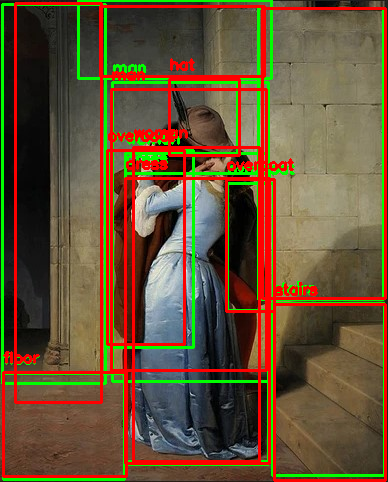

In [66]:
def display_image_with_labels(image_path, label_file_path):
    # Load the image
    image = cv2.imread(image_path)

    # Read the label file and parse bounding box coordinates and class names
    with open(label_file_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        data = line.strip().split()
        class_name = data[0]

        # Extract absolute pixel coordinates from the formatted strings
        x = float(data[1].strip('[],'))
        y = float(data[2].strip(','))
        width = float(data[3].strip(','))
        height = float(data[4].strip(']'))

        # Convert to integers based on image dimensions
        image_h, image_w, _ = image.shape
        x_min = int(x - width / 2)
        y_min = int(y - height / 2)
        x_max = int(x + width / 2)
        y_max = int(y + height / 2)

        # Define colors for bounding boxes (you can customize these)
        color = (0, 255, 0)  # Green

        # Draw bounding boxes and labels on the image
        label = class_name
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    label_file_name = os.path.splitext(image_file)[0]
    label_path = os.path.join(image_directory, f'{label_file_name}.txt')

    # Read the label file and parse bounding box coordinates
    with open(label_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        data = line.strip().split()
        class_id = int(data[0])
        class_name = data[0]
        x_center, y_center, width, height = map(float, data[1:])

        # Convert YOLO format coordinates to image coordinates
        image_h, image_w, _ = image.shape
        x_center *= image_w
        y_center *= image_h
        width *= image_w
        height *= image_h

        # Calculate bounding box coordinates
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        # Get the class name based on class_id
        class_name = class_names.get(str(class_id), 'Unknown')

        # Define colors for bounding boxes (you can customize these)
        color = (0, 0, 255)  # Green
        label = f'{class_name}'  # Display class name instead of class_id

        # Draw bounding boxes and labels on the image
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image with bounding boxes and labels
    cv2_imshow(image)

# Define the directory containing the images and the path for the label directory
image_directory = '/content/drive/MyDrive/all_data_final/predict'

# List all the image files in the input directory
image_files = [f for f in os.listdir(image_directory) if f.endswith('.jpg')]

for image_file in image_files:
    # Construct the full image and label file paths
    image_path = os.path.join(image_directory, image_file)
    label_file = os.path.splitext(image_file)[0] + '_predicted_results.txt'
    label_file_path = os.path.join(image_directory, label_file)

    # Display the image with labels
    display_image_with_labels(image_path, label_file_path)



## $3^{rd}$ Task : Connect with **_Bard_ API** in order to have a description for an image<a class="anchor" id="q3"></a>
We will now connect to an **_Bard API_** in order to be able to create a nice description for our image.<br>
Below is the code that prepares our question to the **_Bard API_**.

In [15]:
# Define the directory containing the images and the path for the output directory where predicted results will be saved
pred_directory = '/content/drive/MyDrive/all_data_final/predict'
# Create a list to store descriptions for all text files
all_descriptions = []

# List all text files in the input directory that end with 'predicted_results.txt'
predicted_result_files = [f for f in os.listdir(pred_directory) if f.endswith('predicted_results.txt')]

# Loop through each text file and generate descriptions
for result_file in predicted_result_files:
    result_file_path = os.path.join(pred_directory, result_file)

    # Read the contents of the text file
    with open(result_file_path, 'r') as file:
        lines = file.readlines()

    # Create a list to store the extracted information
    predictions = []

    # Parse each line of the text file
    for line in lines:
        parts = line.strip().split(' ')
        class_name = parts[0]

        # Extract the bounding box coordinates
        bbox_str = ' '.join(parts[1:])
        # Remove square brackets and commas
        bbox_str = bbox_str.replace('[', '').replace(']', '').replace(',', '')
        # Split the string into individual coordinates
        bbox_parts = bbox_str.split()
        # Convert the coordinates to floats
        bbox = [float(coord) for coord in bbox_parts]

        # Append the information as a dictionary
        predictions.append({'class_name': class_name, 'bbox': bbox})

    # Generate a description using the predictions for the current text file
    def generate_description(predictions):
        description = "I detected the following objects in the image:\n"

        for i, prediction in enumerate(predictions, start=1):
            class_name = prediction['class_name']
            bbox = prediction['bbox']

            description += f"{i}. {class_name} at coordinates {bbox}\n"
        description += "Can you describe an image using the above labels and bounding boxes to visually impaired humans? Do not return bounding boxes numbers, only text. Print only the answer."

        return description

    # Generate a description for the current text file
    description = generate_description(predictions)

    # Create the output description file name
    description_file_name = result_file.replace("_predicted_results.txt", "_description.txt")
    description_file_path = os.path.join(pred_directory, description_file_name)

    # Save the description to the output file
    with open(description_file_path, 'w') as description_file:
        description_file.write(description)

    # Append the description file path to the list of all descriptions
    all_descriptions.append(description_file_path)

# Print or use the generated descriptions for all text files
for description_file_path in all_descriptions:
    print(f"Description saved to: {description_file_path}")

Description saved to: /content/drive/MyDrive/all_data_final/predict/0-02-05-b67c5d21691213169d0c8e1cc879de9730ad7c5521c2d58d1c679a4588759db6_3e2d5c23dfc4efd1_description.txt


We will now connect to **_Bard API_** in order to bring us a text description for our evaluation images.

In [ ]:
# Create a list to store response text files
all_response_files = []

# List all description text files in the input directory
description_files = [f for f in os.listdir(pred_directory) if f.endswith('_description.txt')]

# Loop through each description file and generate desired responses
for description_file in description_files:
    description_file_path = os.path.join(pred_directory, description_file)

    # Read the contents of the description text file
    with open(description_file_path, 'r') as file:
        description = file.read()

    # Token and Bard initialization (assuming you have the token)
    token = 'XXXXXXX.' # Replace this with your token
    bard = Bard(token=token)

    # Get the desired response from Bard
    answer = bard.get_answer(description)['content']
    print(answer)
    print("----------")
    # Split the text into lines
    lines = answer.splitlines()

    # Remove the first and last lines
    lines = lines[1:-1]
    lines = [line.replace('*', '') for line in lines] # Remove any asterisk
    # Join the remaining lines back into a single string
    desired_response = '\n'.join(lines)
    print(desired_response)
    print("----------")
    print("----------")

    # Create the output response file name
    response_file_name = description_file.replace("_description.txt", "_desired_response.txt")
    response_file_path = os.path.join(pred_directory, response_file_name)

    # Save the desired response to the output file
    with open(response_file_path, 'w') as response_file:
        response_file.write(desired_response)

    # Append the response file path to the list of all response files
    all_response_files.append(response_file_path)

# Print or use the generated desired response files for all description files
for response_file_path in all_response_files:
    print(f"Desired response saved to: {response_file_path}")

## $4^{th}$ Task : Transform **_text_** to **_sound_**<a class="anchor" id="q4"></a>
We will now use **_gTTS_** python library in order to be able to create a audible description for our image.

In [ ]:
# Create a list to store audio files
all_audio_files = []

# List all desired response text files in the input directory
response_files = [f for f in os.listdir(pred_directory) if f.endswith('_desired_response.txt')]

# Loop through each response file and generate audio files
for response_file in response_files:
    response_file_path = os.path.join(pred_directory, response_file)

    # Read the contents of the desired response text file
    with open(response_file_path, 'r') as file:
        desired_response = file.read()

    # Generate the audio file using gTTS
    audio = gTTS(text=desired_response, lang="en", slow=False)

    # Create the output audio file name
    audio_file_name = response_file.replace("_desired_response.txt", "_example.mp3")
    audio_file_path = os.path.join(pred_directory, audio_file_name)

    # Save the audio to the output file
    audio.save(audio_file_path)

    # Append the audio file path to the list of all audio files
    all_audio_files.append(audio_file_path)

# Play or use the generated audio files for all desired response files
for audio_file_path in all_audio_files:
    display(Audio(audio_file_path, autoplay=True))